# LA Cell Optimization Using `act`

This notebook compares ACT's quality in original and segregated modes on the [[LA: Cell_A]](https://github.com/cyneuro/current-channel-library/tree/main/Alturki2016/4_LA) example from Alturki2016. The cell's true parameters are
- `glbar_leak = 5.5e-5`
- `gna = 0.000142`
- `gkdr = 0.0015`

ACT can run in original and segregated modes. In the original mode, ACT estimates all parameters on the whole voltage trace. In the segregated mode, ACT cuts specified regions from simulated and target voltage traces and estimates only the region-specific parameters (e.g., `gna` and `gkdr` for a spiking region). Segregated estimation is sequential and requires updating the hoc file after each step. The voltage bounds
- $V_m \in (-\inf; -67.5)$ (leak)
- $V_m \in (-67.5; -55]$ (Na)
- $V_m \in (-55; +\inf]$ (Kdr)

are taken directly from the modfiles.

Below we fit naive and non-naive linear optimizers in the original mode to the original data and the same optimizers in both the original and segregated modes to the segreagated data.

Ensure the modfiles for the corresponding **data** are in the same folder as this notebook before running cells below (you need to swap them from original to segregated as you execute subsections 2. and 3. below).

In [1]:
# Default summary model
from act.feature_model import DefaultSummaryModel

# Default optimizers
from act.optim import NaiveLinearOptimizer, RandomSearchLinearOptimizer

# Default metrics
from act.metrics import correlation_score, plot_score

import torch
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Data Simulation Pipeline

Datafiles `orig/orig_cellA.csv` and `seg/seg_cellA.csv` were generated by compiling Original and Segregated modfiles respectively and running the code below (commented for safety) with respective modfiles.

In [2]:
# Data simulation pipeline for the segregated cell

# glbar_leak = 5.5e-5
# gna = 0.000142
# gkdr = 0.0015

# parameter_samples = np.array([glbar_leak, gna, gkdr])

# from act.optim import ACTOptimizer
# sim = ACTOptimizer("seg_config.json")
# data = sim.simulate(parameter_samples)
# np.savetxt("cell_A.csv", data.T, delimiter = ',')

In [3]:
# Load observed data for a original cell
orig_data = torch.tensor(pd.read_csv("orig/orig_cell_A.csv", header = None).to_numpy()).float()
orig_data = orig_data.T


# Load observed data for a segregated cell
seg_data = torch.tensor(pd.read_csv("seg/seg_cell_A.csv", header = None).to_numpy()).float()
seg_data = seg_data.T

print(f"Data shapes check: original = {orig_data.shape}, segregated = {seg_data.shape}")

Data shapes check: original = torch.Size([5, 4001]), segregated = torch.Size([5, 4001])


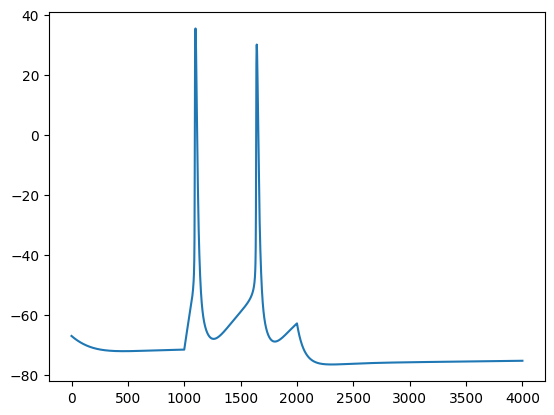

In [4]:
plt.plot(orig_data[0])

## Naive Linear Optimizer

### 1. ACT Mode: Original, Data: Original

In [6]:
oo_naive_lin_opt = NaiveLinearOptimizer("orig/orig_config.json")

oo_naive_lin_opt_estimates = oo_naive_lin_opt.optimize(observed_data = orig_data, num_epochs = 100, 
                                                       lr = 1e-6, return_loss_history = False)

In [7]:
np.set_printoptions(suppress = True)
oo_naive_lin_opt_estimates

array([[0.00005605, 0.0001465 , 0.003     ],
       [0.00005605, 0.0001465 , 0.003     ],
       [0.00005605, 0.0001465 , 0.003     ],
       [0.00005605, 0.0001465 , 0.003     ],
       [0.00005605, 0.0001465 , 0.003     ]], dtype=float32)

### 2. ACT Mode: Original, Data: Segregated

In [5]:
os_naive_lin_opt = NaiveLinearOptimizer("seg/seg_config.json")

os_naive_lin_opt_estimates = os_naive_lin_opt.optimize(observed_data = seg_data, num_epochs = 100, 
                                                       lr = 1e-6, return_loss_history = False)

In [6]:
np.set_printoptions(suppress = True)
os_naive_lin_opt_estimates

array([[0.00000896, 0.00016077, 0.0001    ],
       [0.00000896, 0.00016077, 0.0001    ],
       [0.00000896, 0.00016077, 0.0001    ],
       [0.00000896, 0.00016077, 0.0001    ],
       [0.00000896, 0.00016077, 0.0001    ]], dtype=float32)

### 3. ACT Mode: Segregated, Data: Segregated

All the parameters are set to their lower bounds in the hoc file.

In [4]:
ss_naive_lin_opt = NaiveLinearOptimizer("seg/seg_config.json")

In [5]:
seg_data.mmin()

tensor(-78.0034)

In [6]:
ss_naive_lin_opt_estimates_passive = ss_naive_lin_opt.optimize_with_segregation(observed_data = seg_data, num_epochs = 100, 
                                                                                lr = 1e-6, return_loss_history = False,
                                                                                parameter_inds = [0], 
                                                                                voltage_bounds = [-100, -67.5])

In [7]:
ss_naive_lin_opt_estimates_passive
# Update the hoc file

array([[9.5e-05],
       [9.5e-05],
       [9.5e-05],
       [9.5e-05],
       [9.5e-05]], dtype=float32)

In [8]:
ss_naive_lin_opt = NaiveLinearOptimizer("seg/seg_config.json")
ss_naive_lin_opt_estimates_na = ss_naive_lin_opt.optimize_with_segregation(observed_data = seg_data, num_epochs = 100, 
                                                                            lr = 1e-6, return_loss_history = False,
                                                                            parameter_inds = [1], voltage_bounds = [-67.5, -55])

In [9]:
ss_naive_lin_opt_estimates_na
# Update the hoc file

array([[0.0002],
       [0.0002],
       [0.0002],
       [0.0002],
       [0.0002]], dtype=float32)

In [10]:
ss_naive_lin_opt = NaiveLinearOptimizer("seg/seg_config.json")
ss_naive_lin_opt_estimates_k = ss_naive_lin_opt.optimize_with_segregation(observed_data = seg_data, num_epochs = 100, 
                                                                            lr = 1e-6, return_loss_history = False,
                                                                            parameter_inds = [2], voltage_bounds = [-55, 100])

In [11]:
ss_naive_lin_opt_estimates_k

array([[0.00297887],
       [0.00297887],
       [0.00297887],
       [0.00297887],
       [0.00297887]], dtype=float32)

### 4. Quality

[0.91349316 0.91349316 0.91349316 0.91349316 0.91349316]


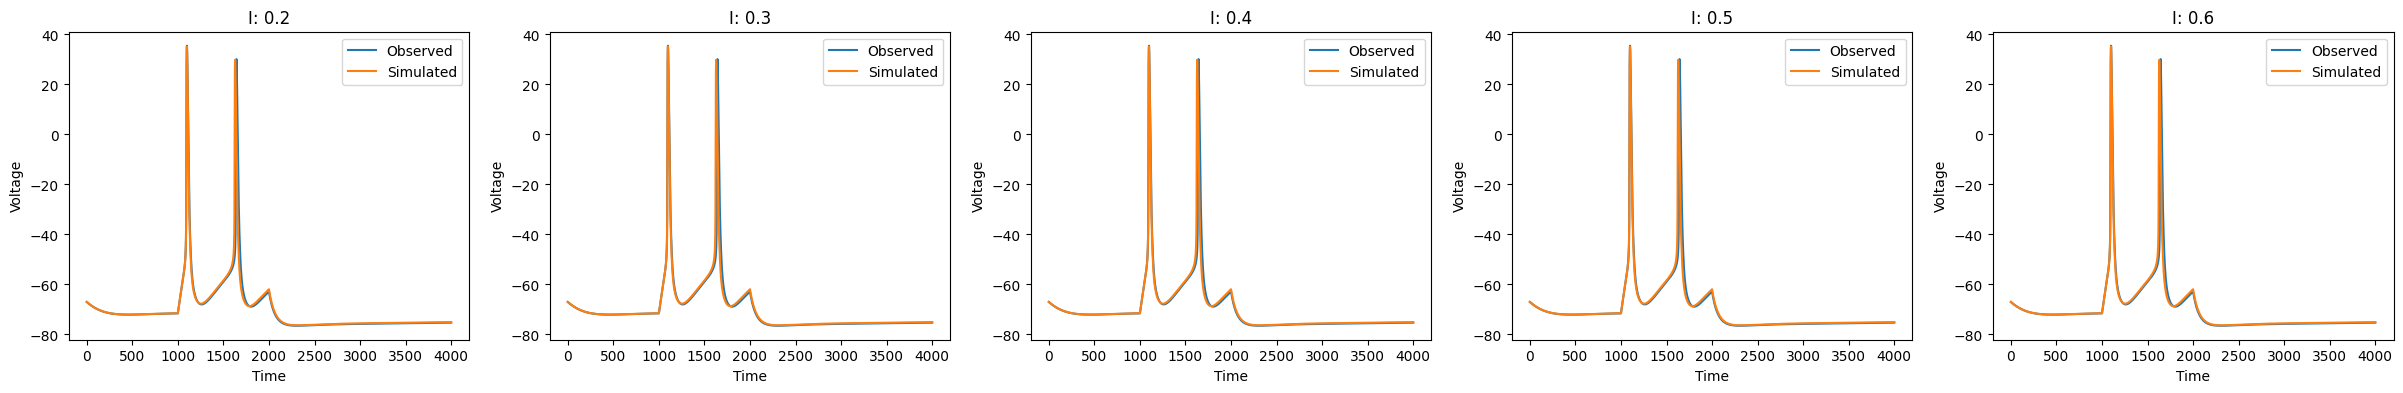

In [9]:
# ACT: Original
# Mod: Original
print(correlation_score(oo_naive_lin_opt, orig_data, oo_naive_lin_opt_estimates[0]))
plot_score(oo_naive_lin_opt, orig_data, oo_naive_lin_opt_estimates[0])

[0.97297605 0.97297605 0.97297605 0.97297605 0.97297605]


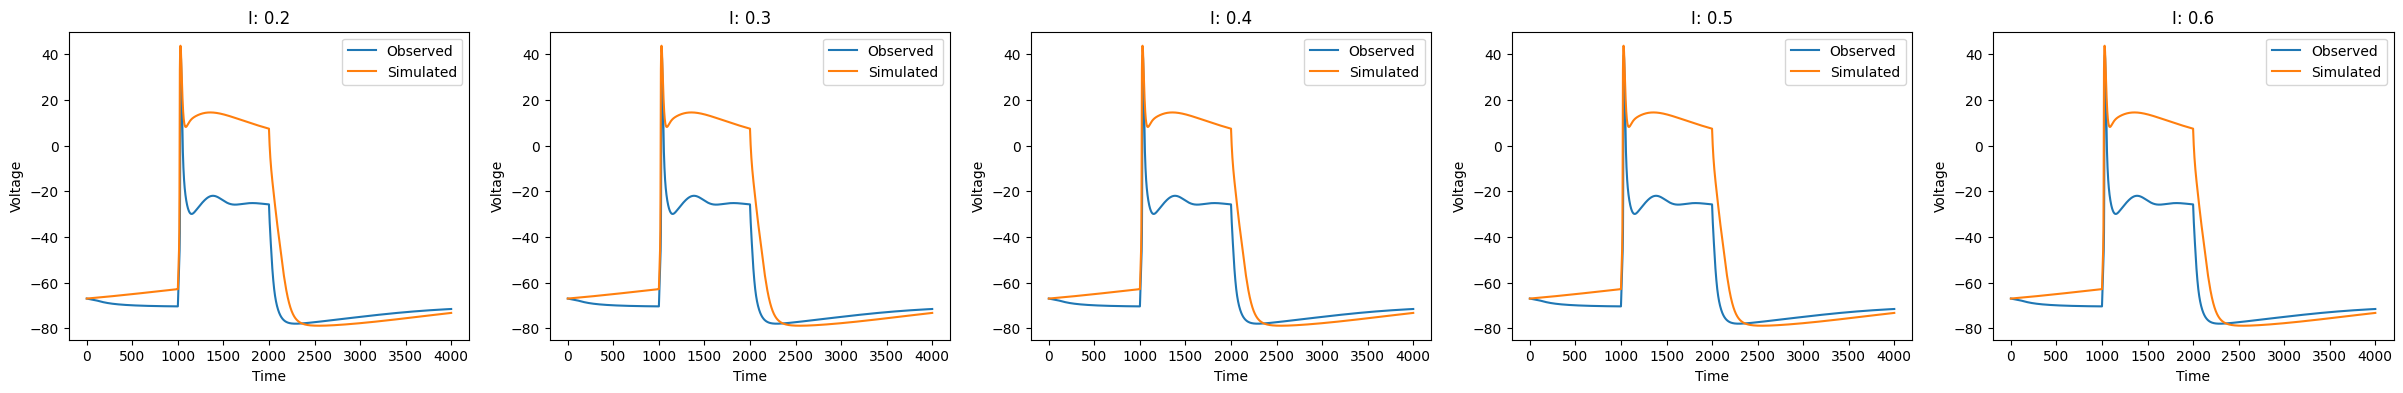

In [13]:
# ACT: Original
# Modfiles: Seg
print(correlation_score(os_naive_lin_opt, seg_data, os_naive_lin_opt_estimates[0]))
plot_score(os_naive_lin_opt, seg_data, os_naive_lin_opt_estimates[0])

[0.98410922 0.98410922 0.98410922 0.98410922 0.98410922]


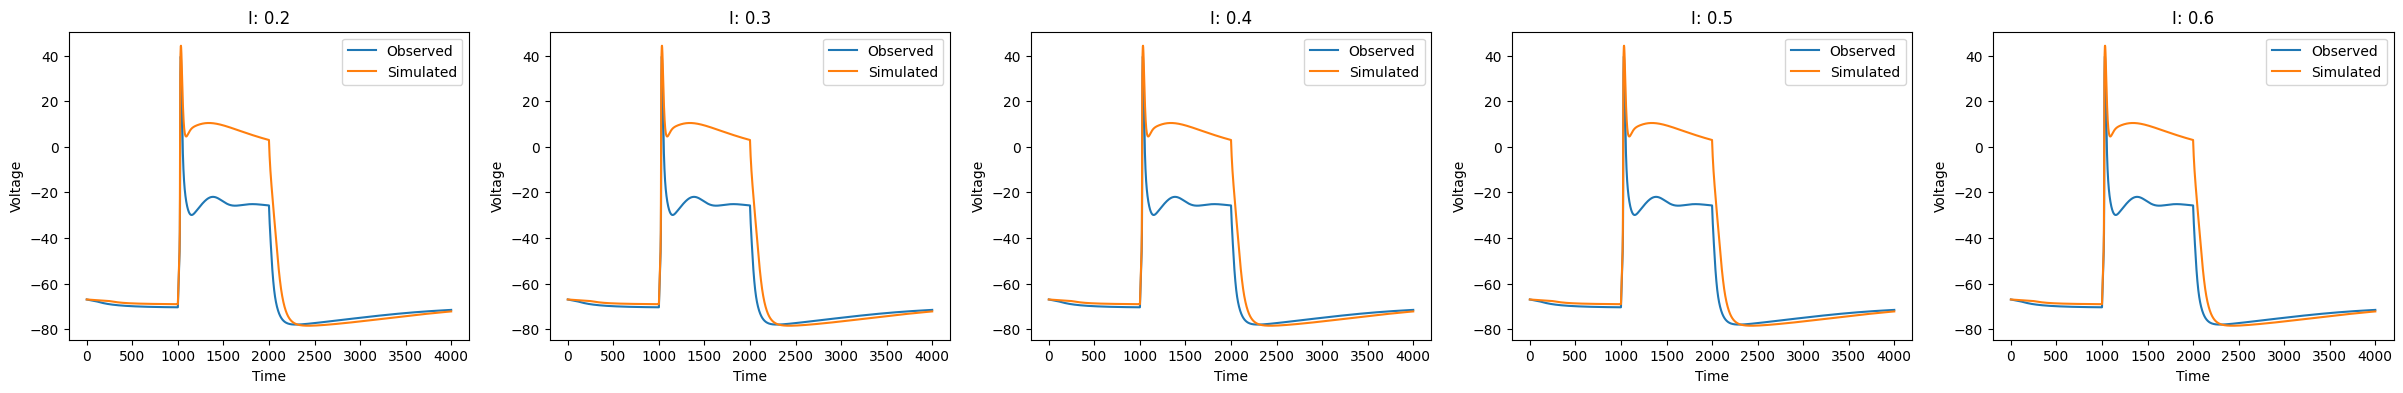

In [12]:
# ACT: Seg
# Modfiles: Seg
ss_naive_lin_opt_estimates = np.hstack((ss_naive_lin_opt_estimates_passive, ss_naive_lin_opt_estimates_spiking))[0]
print(correlation_score(ss_naive_lin_opt, seg_data, ss_naive_lin_opt_estimates))
plot_score(ss_naive_lin_opt, seg_data, ss_naive_lin_opt_estimates)

[0.99075234 0.99075234 0.99075234 0.99075234 0.99075234]


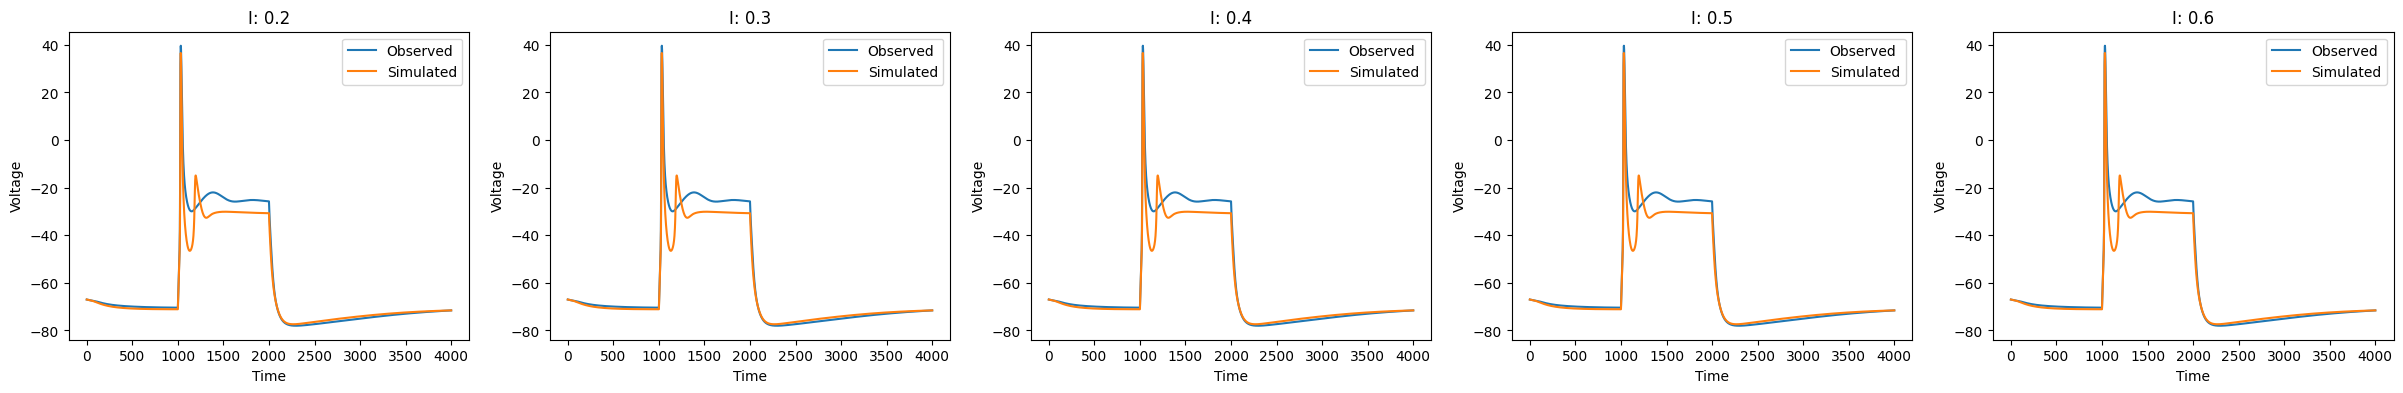

In [12]:
# ACT: Seg
# Modfiles: Seg
ss_naive_lin_opt_estimates = [9.5e-05, 0.0002, 0.00297887]
print(correlation_score(ss_naive_lin_opt, seg_data, ss_naive_lin_opt_estimates))
plot_score(ss_naive_lin_opt, seg_data, ss_naive_lin_opt_estimates)

## Linear Optimizer

### 1. ACT mode: Original, Data: Original

In [10]:
# Define the feature model
oo_feature_model = DefaultSummaryModel(num_summary_features = 61, num_linear_layer_input_features = 250, use_statistics = True)

# Define optimizer
oo_linopt = RandomSearchLinearOptimizer(config_file = "orig/orig_config.json")

Total number of summary features: 64


In [11]:
# Optimize
oo_linopt_estimates = oo_linopt.optimize(feature_model = oo_feature_model, observed_data = orig_data, num_summary_features = 64, 
                                         num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, return_loss_history = False)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [13]:
np.set_printoptions(suppress = True)
oo_linopt_estimates

array([0.00008885, 0.00018833, 0.00298837])

### 2. ACT Mode: Original, Data: Segregated

In [16]:
# Define the feature model
os_feature_model = DefaultSummaryModel(num_summary_features = 61, num_linear_layer_input_features = 250, use_statistics = True)

# Define optimizer
os_linopt = RandomSearchLinearOptimizer(config_file = "seg/seg_config.json")

Total number of summary features: 64


In [17]:
# Optimize
os_linopt_estimates = os_linopt.optimize(feature_model = os_feature_model, observed_data = seg_data, num_summary_features = 64, 
                                         num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, return_loss_history = False)

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [18]:
np.set_printoptions(suppress = True)
os_linopt_estimates

array([0.00003161, 0.0001906 , 0.00185821])

### 3. ACT Mode: Segregated, Data: Segregated

All the parameters are set to their lower bounds in the hoc file.

In [7]:
# Define the feature model
ss_feature_model = DefaultSummaryModel(num_summary_features = 61, num_linear_layer_input_features = 250, use_statistics = True)

# Define optimizer
ss_linopt = RandomSearchLinearOptimizer(config_file = "seg/seg_config.json")

ss_linopt_estimates_passive = ss_linopt.optimize_with_segregation(feature_model = ss_feature_model, voltage_bounds = [-100, -67.5], 
                                                                  parameter_inds = [0], observed_data = seg_data, num_summary_features = 64, 
                                                                  num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, 
                                                                  return_loss_history = False)

torch.Size([5, 4001])


In [8]:
ss_linopt_estimates_passive
# And fix in the hoc file

array([7.60003636e-05])

In [10]:
# Define optimizer
ss_linopt = RandomSearchLinearOptimizer(config_file = "seg/seg_config.json")

# Redefine the feature model
ss_feature_model = DefaultSummaryModel(num_summary_features = 61, num_linear_layer_input_features = 250, use_statistics = True)

ss_linopt_estimates_na = ss_linopt.optimize_with_segregation(feature_model = ss_feature_model, voltage_bounds = [-67.5, -55], 
                                                                  parameter_inds = [1], observed_data = seg_data, 
                                                                  num_summary_features = 64, 
                                                                  num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, 
                                                                  return_loss_history = False)

Total number of summary features: 64
torch.Size([5, 4001])


In [11]:
ss_linopt_estimates_na
# And fix in the hoc file

array([0.00017674])

In [12]:
# Define optimizer
ss_linopt = RandomSearchLinearOptimizer(config_file = "seg/seg_config.json")

# Redefine the feature model
ss_feature_model = DefaultSummaryModel(num_summary_features = 61, num_linear_layer_input_features = 250, use_statistics = True)

ss_linopt_estimates_k = ss_linopt.optimize_with_segregation(feature_model = ss_feature_model, voltage_bounds = [-55, 100], 
                                                             parameter_inds = [2], observed_data = seg_data, 
                                                             num_summary_features = 64, 
                                                             num_epochs = 800, num_prediction_rounds = 800, lr = 1e-5, 
                                                             return_loss_history = False)

Total number of summary features: 64
torch.Size([5, 4001])


In [13]:
ss_linopt_estimates_k
# And fix in the hoc file

array([0.00065458])

### 4. Quality

[0.99950818 0.99950818 0.99950818 0.99950818 0.99950818]


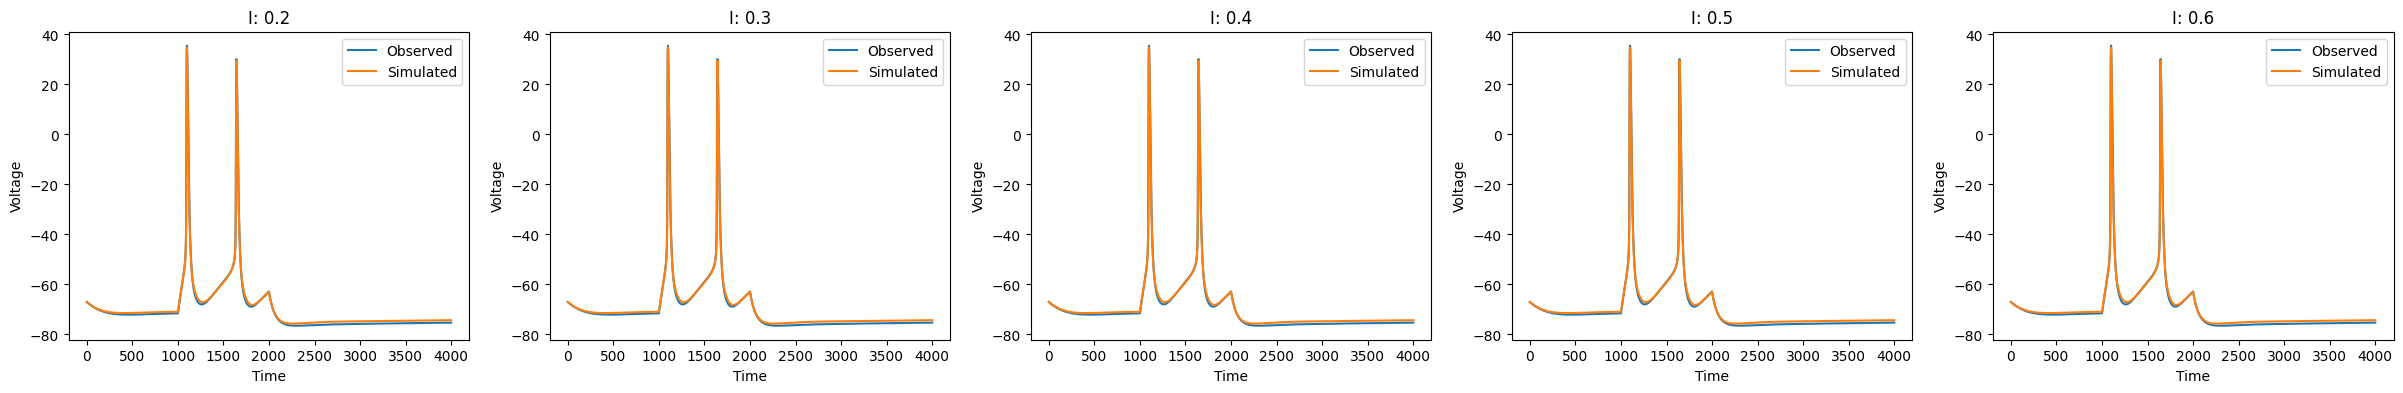

In [14]:
# ACT: Orig
# Mod: Orig
print(correlation_score(oo_linopt, orig_data, oo_linopt_estimates))
plot_score(oo_linopt, orig_data, oo_linopt_estimates)

[0.99073337 0.99073337 0.99073337 0.99073337 0.99073337]


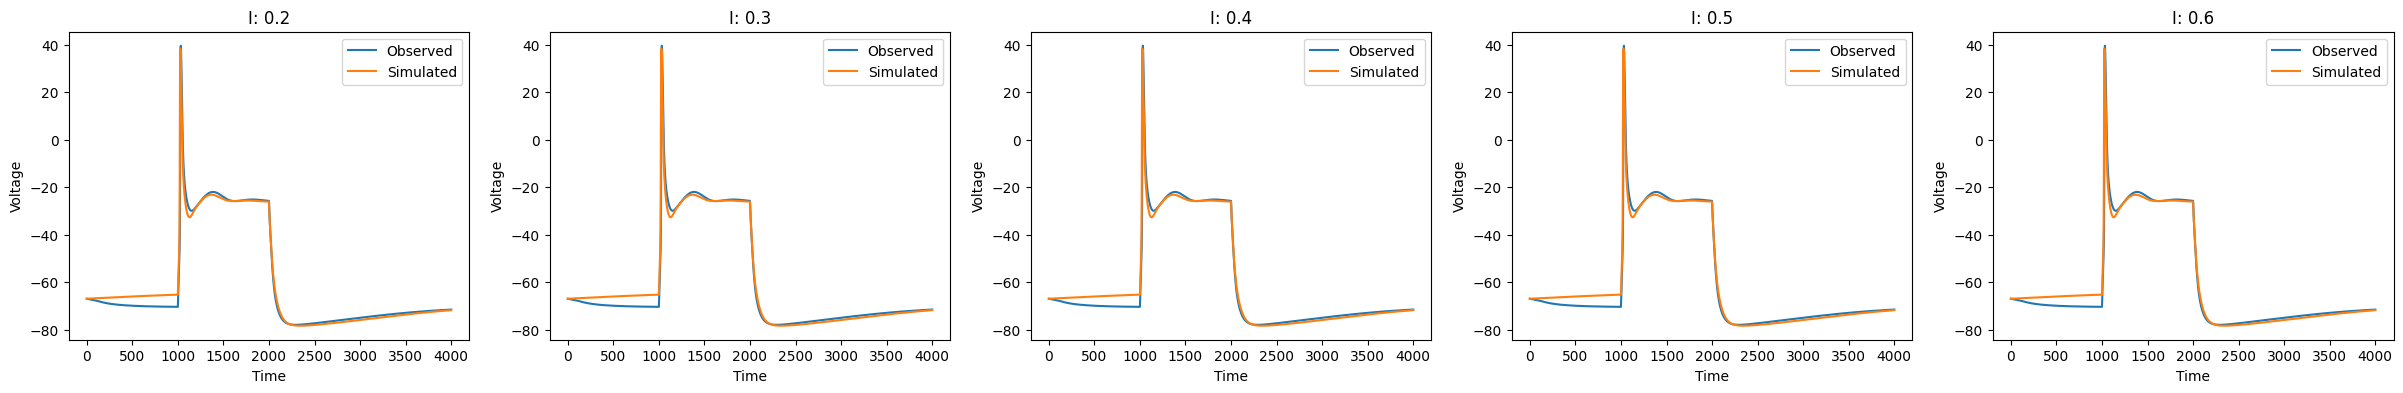

In [24]:
# ACT: Orig
# Mod: Seg
print(correlation_score(os_linopt, seg_data, os_linopt_estimates))
plot_score(os_linopt, seg_data, os_linopt_estimates)

[0.99313312 0.99313312 0.99313312 0.99313312 0.99313312]


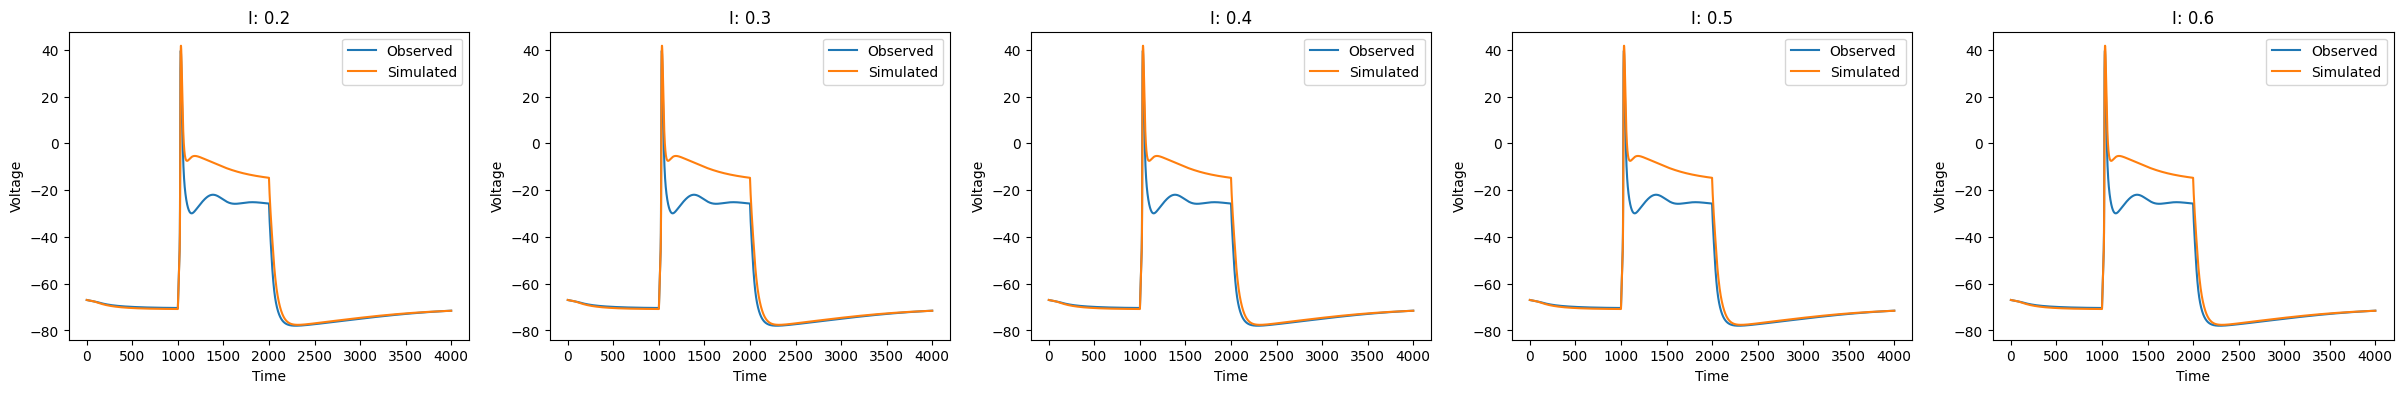

In [16]:
# ACT: Seg
# Mod: Seg
ss_linopt_estimates = np.hstack((ss_linopt_estimates_passive, ss_linopt_estimates_na, ss_linopt_estimates_k))
print(correlation_score(ss_linopt, seg_data, ss_linopt_estimates))
plot_score(ss_linopt, seg_data, ss_linopt_estimates)